In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

In [2]:
df = pd.read_csv('tweets.csv', 
                 encoding = "ISO-8859-1", 
                 names = ['target','id','datetime','flag','user','text'])

In [3]:
df.head()

,target,id,datetime,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   datetime  1600000 non-null  object
 3   flag      1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df['target'].unique()

array([0, 4], dtype=int64)

Let us encode it to 0 and 1.

In [6]:
df['target'] = df['target'].replace(4,1)
df['target'].unique()

array([0, 1], dtype=int64)

<AxesSubplot:xlabel='target', ylabel='count'>

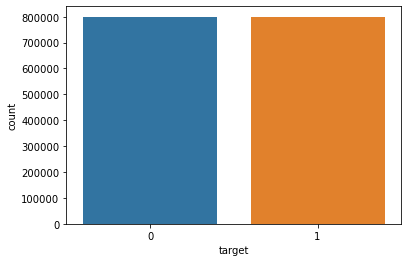

In [7]:
sns.countplot(x='target', data=df)

Data shows equal distribution of negative and positive targets.

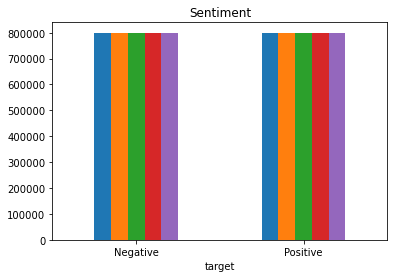

In [8]:
ax = df.groupby('target').count().plot(kind='bar', title='Sentiment',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

In [9]:
text_target = df[['text','target']]
pos = text_target[text_target['target'] == 1]
neg = text_target[text_target['target'] == 0]
df_new = pd.concat([pos, neg])
df_new['text']=df_new['text'].str.lower()

df_new.sample(7)

,text,target
153553,oooh headache starting... too much computer ma...,0
868312,@smittnbybritain make sure save me some - yum,1
1452910,@mariekccberry im one of the lucky few who got...,1
1474969,most of my followers must be at church this mo...,1
1364649,utah tomorrow i want it to be june 26th or ju...,1
459151,laying with boozer cuddling then bed... we jus...,0
1199527,watching the hills finale and then the mtv mov...,1


Now, we perform stopwords and punctuation removal as usual using nltk.

In [10]:
from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))
def removeStopWords(text):
    return " ".join([i for i in str(text).split() if i not in stopWords])

df_new['text'] = df_new['text'].apply(lambda text: removeStopWords(text))
df_new.sample(7)

,text,target
914808,"@thej cong govt ruling karnataka, cauvery foun...",1
639682,@mario_nyc lol over-protective big brother_nyc...,0
553908,"@petewentz i'm not, could talk me. no-one talk...",0
1362088,@supershara heeh yuppers lots traveling spread...,1
1453752,@jazzjeppe good morning sunshine! â« http://b...,1
270732,oh monday morning! headache,0
675342,"really sick ferret, i'm scared",0


In [11]:
import string
punc_list = string.punctuation

def removePunc(text):
    transl = str.maketrans('', '', punc_list)
    return text.translate(transl)

df_new['text']= df_new['text'].apply(lambda x: removePunc(x))
df_new['text'].sample(7)

734841                                     hands peeeeeeeely
321245     longer writing article costco connection je su...
300248                                        cant take hurt
1216107                       hanlie thank you wait next one
1384582                        im really depressed right now
485966     thereasonwhy hope car gets fixed soon gotta dr...
289891     thehoosiersuk aww poor peanut hope everything ...
Name: text, dtype: object

We will now use regex to remove any hyperlinks/URLs and numbers in the tweets as they can mistrain the model.

In [12]:
import re
def removeHyperLinks(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
def removeNumbers(data):
    return re.sub('[0-9]+', '', data)

df_new['text'] = df_new['text'].apply(lambda x: removeHyperLinks(x))
df_new['text'] = df_new['text'].apply(lambda x: removeNumbers(x))
df_new['text'].sample(7)

622308                               dude bringing memories
487216     donniewahlberg really sucks u guys cant go under
801445    drbaher love list tick people off actually qui...
600840    heard today shop worked last month closing wit...
273846    elizabethrose way totally expecting behind ene...
437502    owww stretching think pulled effing muscle rig...
338595    charleybum sorry late reply drama camp haha na...
Name: text, dtype: object

Now that text processing is done, we will tokenize the text and perform stemming and lemmatizing. 

In [13]:
from nltk.tokenize import RegexpTokenizer
tkz = RegexpTokenizer(r'w+')
df_new['text'] = df_new['text'].apply(tkz.tokenize)
df_new['text'].sample(7)

1322319    [w, w, w, w]
501215               []
561319               []
320946              [w]
916409               []
354640               []
1548872       [w, w, w]
Name: text, dtype: object

In [14]:
import nltk
ps = nltk.PorterStemmer()
def textStem(text):
    stem_text = [ps.stem(i) for i in text]
    return text

wnl = nltk.WordNetLemmatizer()
def textLemmatize(text):
    lemma_text = [wnl.lemmatize(i) for i in text]
    return text

df_new['text']= df_new['text'].apply(lambda x: textStem(x))
df_new['text'] = df_new['text'].apply(lambda x: textLemmatize(x))
df_new['text'].sample(7)

1410119       [w, w]
305681            []
1221440       [w, w]
1356775          [w]
179533           [w]
818442           [w]
276790     [w, w, w]
Name: text, dtype: object

Now, we will finally train some models using train and test data.

In [15]:
from sklearn.model_selection import train_test_split
X = text_target.text
y = text_target.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =101)

To transform the dataset, we will use TFIDF vectorizer instead of CountVectorizer. This is because unlike CV, TFIDF does not give equal weightage to all the words and simply return counts, instead it assigns a certain score to each word and returns a more accurate float value. 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)

X_train = tfidf.transform(X_train)
X_test  = tfidf.transform(X_test)

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
def testModel(model):

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    groups = ['True Neg','False Pos', 'False Neg','True Pos']
    groupsPerc = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(groups, groupsPerc)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot = labels, 
                cmap = 'Blues', fmt = '',
                xticklabels = categories, 
                yticklabels = categories)
    
    plt.xlabel("Predicted", fontdict = {'size' : 12}, labelpad = 10)
    plt.ylabel("Actual" , fontdict = {'size' : 12}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size' : 12}, pad = 20)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82    159763
           1       0.82      0.82      0.82    160237

    accuracy                           0.82    320000
   macro avg       0.82      0.82      0.82    320000
weighted avg       0.82      0.82      0.82    320000



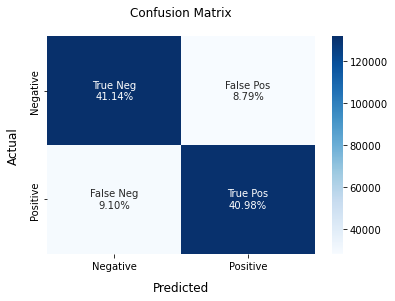

In [22]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)
testModel(svc)
svc_y_pred = svc.predict(X_test)